### Simple example

In [11]:
import os
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax import grad, jacobian, hessian

from jax.scipy.special import gammainc

In [6]:
grad_tanh = grad(jnp.tanh)


In [7]:
def my_fn(x):
    return jnp.sum(x**2)

grad_my_fn = grad(my_fn)
hess_my_fn = hessian(my_fn)

In [10]:
x0 = jnp.array([1., 2.])

print(grad_my_fn(x0),
      hess_my_fn(x0), sep='\n')

[2. 4.]
[[2. 0.]
 [0. 2.]]


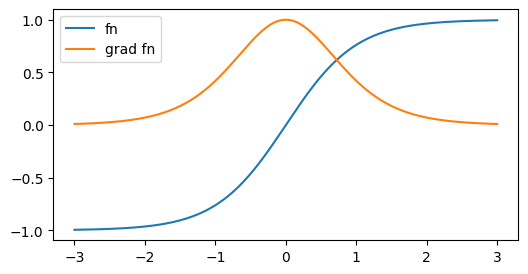

In [16]:
x = np.linspace(-3, 3, 200)

plt.figure(figsize=(6,3))
plt.plot(x, jnp.tanh(x), label='fn')
plt.plot(x, [grad_tanh(x_i) for x_i in x], label='grad fn')

plt.legend()
plt.show()

### Regression example

In [1]:
import os
import sys
import time

import numpy as np
import pandas as pd
import lightgbm as lgb
import jax.numpy as jnp
import matplotlib.pyplot as plt

# from sklearn.datasets import load_boston
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

from functools import partial
from jax import jit, grad, jacobian, hessian, jvp


In [2]:
housing = fetch_california_housing()

In [3]:
housing.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [4]:
_ = """
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude
"""

housing['data'].shape, housing.target.shape, housing['feature_names']

((20640, 8),
 (20640,),
 ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'])

In [5]:
x_tr, x_va, y_tr, y_va = train_test_split(housing['data'], housing['target'], train_size=0.7, random_state=12)

ds_tr = lgb.Dataset(
    data=x_tr,
    label=y_tr,
    feature_name=housing['feature_names'],
    reference=None)

ds_va = lgb.Dataset(
    data=x_va,
    label=y_va,
    feature_name=housing['feature_names'],
    reference=ds_tr)


##### P1

In [29]:
lgbm_parameters = {
    'objective': 'regression',
    'metric': ['rmse'],
    'n_estimators': 80,
    'num_leaves': 63,
    'max_depth': 4,
    'learning_rate': .05,
    'lambda_l2': .01,
    'min_data_in_leaf': 50,
    'verbose': -1,
    'early_stopping_rounds': 10,
    'first_metric_only': True}


ti = time.time()
gbm = lgb.train(
    params=lgbm_parameters,
    train_set=ds_tr,
    valid_sets=[ds_tr, ds_va],
    valid_names=['train', 'val'],
    callbacks=[lgb.log_evaluation(period=10, show_stdv=False)])
tf = time.time()
print(tf-ti)

[10]	train's rmse: 0.900226	val's rmse: 0.904938
[20]	train's rmse: 0.768029	val's rmse: 0.772492
[30]	train's rmse: 0.68849	val's rmse: 0.692723
[40]	train's rmse: 0.637129	val's rmse: 0.642123
[50]	train's rmse: 0.601911	val's rmse: 0.608396
[60]	train's rmse: 0.57236	val's rmse: 0.579653
[70]	train's rmse: 0.551448	val's rmse: 0.559352
[80]	train's rmse: 0.538703	val's rmse: 0.547462
0.0761268138885498


In [38]:
print(root_mean_squared_error(y_tr, gbm.predict(x_tr)),
      root_mean_squared_error(y_va, gbm.predict(x_va)), sep='\n')

0.5387029687109844
0.5474619836046731


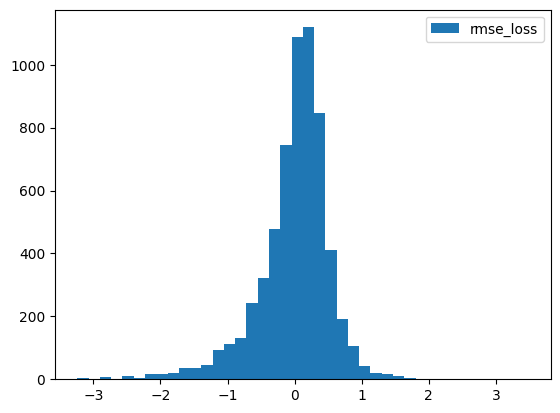

In [48]:
diff_va = gbm.predict(x_va) - y_va

plt.hist(diff_va, label='rmse_loss', bins=40)
plt.legend()
plt.show()

##### P2

In [28]:
def custom_objective(a, ds):
    """ The custom objective is proportional to the negative log-likelihood """

    # (n,)
    y = ds.get_label()
    weight = ds.get_weight()

    # loss        = 1/N * sum^{N}_{i=1} (y-a_i)^2
    # dloss_da_i  = 1/N * 2 * (y - a_i) * (-1)
    # dloss_da2_i = 1/N * 2
    
    grad = - 2. * (y-a)/len(y)
    hess = 2. * np.ones_like(y) / len(y)

    return grad, hess


def learning_rate_schedule(n: int, lr: float) -> float:
    """ Learning rate schedule dependent on the training step n

    Parameters
    ----------
    n: training step
    lr: learning rate
    """

    if n < 1:
        return 1.
    else:
        return lr


lgbm_parameters = {
    'objective': custom_objective,
    'metric': ['rmse'],
    'n_estimators': 80,
    'num_leaves': 63,
    'max_depth': 4,
    'learning_rate': .05,
    'lambda_l2': .01,
    'min_data_in_leaf': 50,
    'verbose': -1,
    'early_stopping_rounds': 10,
    'first_metric_only': True}


ti = time.time()
gbm_2 = lgb.train(
    params=lgbm_parameters,
    train_set=ds_tr,
    valid_sets=[ds_tr, ds_va],
    valid_names=['train', 'val'],
    callbacks=[lgb.log_evaluation(period=10, show_stdv=False),
               lgb.reset_parameter(learning_rate=partial(learning_rate_schedule, lr=lgbm_parameters['learning_rate']))
              ])
tf = time.time()
print(tf-ti)

[10]	train's rmse: 0.745569	val's rmse: 0.750982
[20]	train's rmse: 0.702618	val's rmse: 0.708944
[30]	train's rmse: 0.669485	val's rmse: 0.675561
[40]	train's rmse: 0.64145	val's rmse: 0.647933
[50]	train's rmse: 0.622748	val's rmse: 0.630198
[60]	train's rmse: 0.606928	val's rmse: 0.615446
[70]	train's rmse: 0.594729	val's rmse: 0.604584
[80]	train's rmse: 0.584995	val's rmse: 0.595735
0.1148834228515625


In [60]:
gbm_2.save_model('temp.txt')

##### P3

In [6]:
def my_loss(y_hat, y):
    return jnp.mean((y-y_hat)**2)

grad_my_loss = grad(my_loss)
hess_my_loss = hessian(my_loss)


@jit
def get_grad_hess(y_hat, y):
    
    grad_ = grad_my_loss(y_hat, y)
    hess_ = hess_my_loss(y_hat, y).diagonal()

    return grad_, hess_


@jit
def get_grad_hess_v2(y_hat, y):
    """ Avoid the calculation of the diagonal elements """

    def my_loss_partial(y_hat):
        return my_loss(y_hat, y)

    grad_ = grad_my_loss(y_hat, y)
    hess_ = jvp(grad(my_loss_partial),
                (y_hat,),
                (jnp.ones_like(y_hat),))[1]
    
    return grad_, hess_


def custom_objective(a, ds):
    """ The custom objective is proportional to the negative log-likelihood """

    # (n,)
    y = ds.get_label()
    a = a.astype('float32')

    grad_ = grad_my_loss(a, y)
    hess_ = hess_my_loss(a, y).diagonal()

    # should result in no-copy device transfers if you're on a CPU backend
    grad_ = np.array(grad_, copy=False)
    hess_ = np.array(hess_, copy=False)
    
    return grad_, hess_


def custom_objective_fast(a, ds):
    """ The custom objective is proportional to the negative log-likelihood """

    # (n,)
    y = ds.get_label()
    a = a.astype('float32')

    grad_, hess_ = get_grad_hess(a, y)

    # should result in no-copy device transfers if you're on a CPU backend
    grad_ = np.array(grad_, copy=False)
    hess_ = np.array(hess_, copy=False)
    
    return grad_, hess_


def custom_objective_fastest(a, ds):

    # (n,)
    y = ds.get_label()
    a = a.astype('float32')

    grad_, hess_ = get_grad_hess_v2(a, y)

    # should result in no-copy device transfers if you're on a CPU backend
    grad_ = np.array(grad_, copy=False)
    hess_ = np.array(hess_, copy=False)
    
    return grad_, hess_


def learning_rate_schedule(n: int, lr: float) -> float:
    """ Learning rate schedule dependent on the training step n

    Parameters
    ----------
    n: training step
    lr: learning rate
    """

    if n < 1:
        return 1.
    else:
        return lr


In [7]:
lgbm_parameters = {
    'objective': custom_objective,
    'metric': ['rmse'],
    'n_estimators': 80,
    'num_leaves': 63,
    'max_depth': 4,
    'learning_rate': .05,
    'lambda_l2': .01,
    'min_data_in_leaf': 50,
    'verbose': -1,
    'early_stopping_rounds': 10,
    'first_metric_only': True}


ti = time.time()
gbm_3 = lgb.train(
    params=lgbm_parameters,
    train_set=ds_tr,
    valid_sets=[ds_tr, ds_va],
    valid_names=['train', 'val'],
    callbacks=[lgb.log_evaluation(period=10, show_stdv=False),
               lgb.reset_parameter(learning_rate=partial(learning_rate_schedule, lr=lgbm_parameters['learning_rate']))
              ])

tf = time.time()
print(tf - ti)

/.pyenv/versions/3.12.7/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[10]	train's rmse: 0.745569	val's rmse: 0.750982
[20]	train's rmse: 0.702618	val's rmse: 0.708944
[30]	train's rmse: 0.669485	val's rmse: 0.675561
[40]	train's rmse: 0.64145	val's rmse: 0.647933
[50]	train's rmse: 0.622748	val's rmse: 0.630198
[60]	train's rmse: 0.606928	val's rmse: 0.615446
[70]	train's rmse: 0.594729	val's rmse: 0.604584
[80]	train's rmse: 0.584995	val's rmse: 0.595735
5.123961925506592


In [14]:
lgbm_parameters = {
    'objective': custom_objective_fast,
    'metric': ['rmse'],
    'n_estimators': 80,
    'num_leaves': 63,
    'max_depth': 4,
    'learning_rate': .05,
    'lambda_l2': .01,
    'min_data_in_leaf': 50,
    'verbose': -1,
    'early_stopping_rounds': 10,
    'first_metric_only': True}


ti = time.time()
gbm_3 = lgb.train(
    params=lgbm_parameters,
    train_set=ds_tr,
    valid_sets=[ds_tr, ds_va],
    valid_names=['train', 'val'],
    callbacks=[lgb.log_evaluation(period=10, show_stdv=False),
               lgb.reset_parameter(learning_rate=partial(learning_rate_schedule, lr=lgbm_parameters['learning_rate']))
              ])

tf = time.time()
print(tf - ti)

[10]	train's rmse: 0.745569	val's rmse: 0.750982
[20]	train's rmse: 0.702618	val's rmse: 0.708944
[30]	train's rmse: 0.669485	val's rmse: 0.675561
[40]	train's rmse: 0.64145	val's rmse: 0.647933
[50]	train's rmse: 0.622748	val's rmse: 0.630198
[60]	train's rmse: 0.606928	val's rmse: 0.615446
[70]	train's rmse: 0.594729	val's rmse: 0.604584
[80]	train's rmse: 0.584995	val's rmse: 0.595735
0.14580440521240234


In [36]:
lgbm_parameters = {
    'objective': custom_objective_fastest,
    'metric': ['rmse'],
    'n_estimators': 80,
    'num_leaves': 63,
    'max_depth': 4,
    'learning_rate': .05,
    'lambda_l2': .01,
    'min_data_in_leaf': 50,
    'verbose': -1,
    'early_stopping_rounds': 10,
    'first_metric_only': True}


ti = time.time()
gbm_3 = lgb.train(
    params=lgbm_parameters,
    train_set=ds_tr,
    valid_sets=[ds_tr, ds_va],
    valid_names=['train', 'val'],
    callbacks=[lgb.log_evaluation(period=10, show_stdv=False),
               lgb.reset_parameter(learning_rate=partial(learning_rate_schedule, lr=lgbm_parameters['learning_rate']))
              ])

tf = time.time()
print(tf - ti)

[10]	train's rmse: 0.745569	val's rmse: 0.750982
[20]	train's rmse: 0.702618	val's rmse: 0.708944
[30]	train's rmse: 0.669485	val's rmse: 0.675561
[40]	train's rmse: 0.64145	val's rmse: 0.647933
[50]	train's rmse: 0.622748	val's rmse: 0.630198
[60]	train's rmse: 0.606928	val's rmse: 0.615446
[70]	train's rmse: 0.594729	val's rmse: 0.604584
[80]	train's rmse: 0.584995	val's rmse: 0.595735
0.14855575561523438


##### Move to GPU

In [45]:
def custom_objective_fastest_gpu(a, ds):

    # (n,)
    y = ds.get_label()
    #a = a.astype('float32')

    grad_, hess_ = get_grad_hess_v2(a, y)

    # should result in no-copy device transfers if you're on a CPU backend
    grad_ = np.array(grad_, copy=False)
    hess_ = np.array(hess_, copy=False)
    
    return grad_, hess_


lgbm_parameters = {
    'objective': custom_objective_fastest_gpu,
    'metric': ['rmse'],
    'n_estimators': 80,
    'num_leaves': 63,
    'max_depth': 4,
    'learning_rate': .05,
    'lambda_l2': .01,
    'min_data_in_leaf': 50,
    'verbose': -1,
    'early_stopping_rounds': 10,
    'first_metric_only': True,
    'device_type': 'gpu'  # UPDATE
}


ti = time.time()
gbm_4 = lgb.train(
    params=lgbm_parameters,
    train_set=ds_tr,
    valid_sets=[ds_tr, ds_va],
    valid_names=['train', 'val'],
    callbacks=[lgb.log_evaluation(period=10, show_stdv=False)])
tf = time.time()
print(tf - ti)

[10]	train's rmse: 1.57015	val's rmse: 1.57869
[20]	train's rmse: 1.11825	val's rmse: 1.12557
[30]	train's rmse: 0.86769	val's rmse: 0.874719
[40]	train's rmse: 0.726782	val's rmse: 0.73386
[50]	train's rmse: 0.652445	val's rmse: 0.659189
[60]	train's rmse: 0.611969	val's rmse: 0.618311
[70]	train's rmse: 0.584859	val's rmse: 0.591276
[80]	train's rmse: 0.567408	val's rmse: 0.573705
0.25476670265197754


##### jax tests

In [123]:
def my_fn(x):
    return jnp.mean(x**2)

grad_my_fn = grad(my_fn)
hess_my_fn = hessian(my_fn)

x = jnp.arange(4, dtype='float32')
my_fn(x), grad_my_fn(x), hess_my_fn(x).diagonal()

(Array(3.5, dtype=float32),
 Array([0. , 0.5, 1. , 1.5], dtype=float32),
 Array([0.5, 0.5, 0.5, 0.5], dtype=float32))

In [128]:
res = grad_my_fn(x)
res_ = np.array(res, copy=False)

In [129]:
type(res), type(res_)

(jaxlib.xla_extension.ArrayImpl, numpy.ndarray)

In [131]:
res_[0] = 11.

ValueError: assignment destination is read-only

In [132]:
res[0] = 11.

TypeError: JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [120]:
def my_fn(x):
    return jnp.mean(x**2)

grad_my_fn = grad(my_fn)
hess_my_fn = hessian(my_fn)

x = np.arange(4, dtype='float32')
my_fn(x), grad_my_fn(x), hess_my_fn(x).diagonal()

(Array(3.5, dtype=float32),
 Array([0. , 0.5, 1. , 1.5], dtype=float32),
 Array([0.5, 0.5, 0.5, 0.5], dtype=float32))

In [112]:
def my_fn(x, y):
    return jnp.mean(x**2) + y.mean()

grad_my_fn = grad(my_fn)
hess_my_fn = hessian(my_fn)

x = jnp.arange(4, dtype='float32')
y = jnp.ones((4,), dtype='float32')

my_fn(x,y), grad_my_fn(x,y), hess_my_fn(x,y)

(Array(4.5, dtype=float32),
 Array([0. , 0.5, 1. , 1.5], dtype=float32),
 Array([[0.5, 0. , 0. , 0. ],
        [0. , 0.5, 0. , 0. ],
        [0. , 0. , 0.5, 0. ],
        [0. , 0. , 0. , 0.5]], dtype=float32))

In [10]:
# from jax import jvp, grad, hessian
# import jax.numpy as jnp
import numpy.random as npr

rng = npr.RandomState(0)
a = rng.randn(4)
x = rng.randn(4)

# function with diagonal Hessian that isn't rank-polymorphic
def f(x):
  assert x.ndim == 1
  return jnp.sum(jnp.tanh(a * x))


def hvp(f, x, v):
  return jvp(grad(f), (x,), (v,))[1]

print(hessian(f)(x))
print(jnp.diag(hessian(f)(x)))
print(hvp(f, x, jnp.ones_like(x)))

[[-0.03405552  0.          0.          0.        ]
 [ 0.          0.10269939  0.          0.        ]
 [ 0.          0.         -0.652652    0.        ]
 [ 0.          0.          0.          2.9311914 ]]
[-0.03405552  0.10269939 -0.652652    2.9311914 ]
[-0.03405552  0.10269939 -0.652652    2.9311914 ]
